# Fase 2 del proyecto

La segunda fase consiste en implementar todos los modelos de regresión, ajusstar los parámetros y métricas de rendiiento para cada modelo.

## Cargar y preparación de datos 

In [4]:
import pandas as pd
import numpy as np


df = pd.read_csv("../data_clean/olist_dataset_unificado_clean.csv")

df['order_estimated_delivery_date'] = pd.to_datetime(df['order_estimated_delivery_date'])
df['order_delivered_customer_date'] = pd.to_datetime(df['order_delivered_customer_date'])

#target variable
df['delivery_diff_days'] = (df['order_delivered_customer_date'] - df['order_estimated_delivery_date']).dt.days

# Eliminar nulos en la variable objetivo
df = df.dropna(subset=['delivery_diff_days'])

cols_to_drop = [
    'order_id', 'customer_id', 'customer_unique_id', 'order_purchase_timestamp',
    'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date',
    'order_estimated_delivery_date', 'product_id', 'seller_id', 'shipping_limit_date',
    'review_id', 'review_comment_title', 'review_comment_message', 'review_creation_date',
    'review_answer_timestamp', 'product_category_name', 'product_category_name_english'
]

df = df.drop(columns=cols_to_drop)

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Separar variables
X = df.drop(columns=['delivery_diff_days'])
y = df['delivery_diff_days']

# Codificar dummies para variables categóricas
X = pd.get_dummies(X)

# Escalar
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
print(f"std y_train: {y_train.std()} std y_test: {y_test.std()}")


std y_train: 10.139350943798116 std y_test: 10.221082819528593


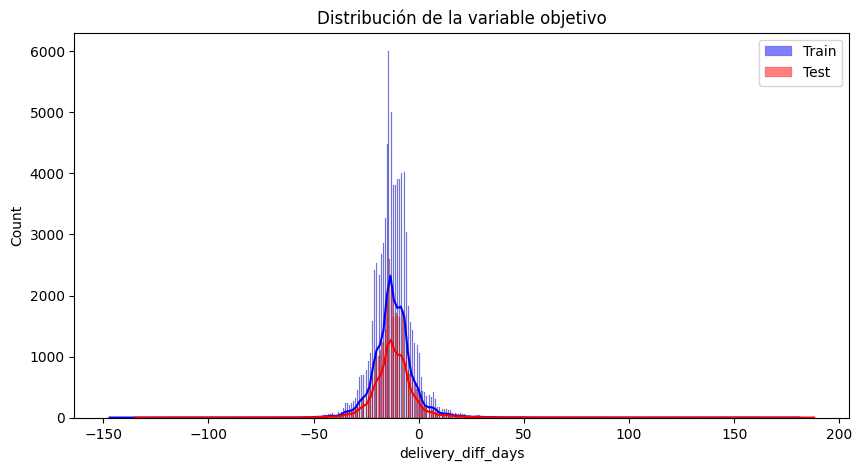

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
sns.histplot(y_train, kde=True, color='blue', label='Train')
sns.histplot(y_test, kde=True, color='red', label='Test')
plt.legend()
plt.title('Distribución de la variable objetivo')
plt.show()

In [7]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

models = {
    "Árbol de Decisión": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=50, random_state=42),
    "Regresión Lineal": LinearRegression()
}

def get_statistics(name: object, y_test, y_pred) -> None:
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    
    print(f"\nResultados para: {name.__class__.__qualname__}")
    print("MAE:", mean_absolute_error(y_test, y_pred))
    print("RMSE:", rmse)
    print("R²:", r2_score(y_test, y_pred))



In [8]:
# predecir promedio para cada muestra
y_pred_baseline = np.full(shape=y_test.shape, fill_value=y_train.mean())

# evaluar baseline
print("Baseline MSE:", mean_squared_error(y_test, y_pred_baseline))
print("Baseline R²:", r2_score(y_test, y_pred_baseline))

Baseline MSE: 104.47216339719978
Baseline R²: -4.440063221311519e-05


In [9]:
# evaluar uno por uno para ver errores 
tree_model = models.get("Árbol de Decisión", None)
tree_model.fit(X_train, y_train) # entrenar
y_pred_tree = tree_model.predict(X_test) # predecir
get_statistics(tree_model, y_test=y_test, y_pred=y_pred_tree)
   


Resultados para: DecisionTreeRegressor
MAE: 7.471370143149284
RMSE: 11.982276568145258
R²: -0.37435008432111516


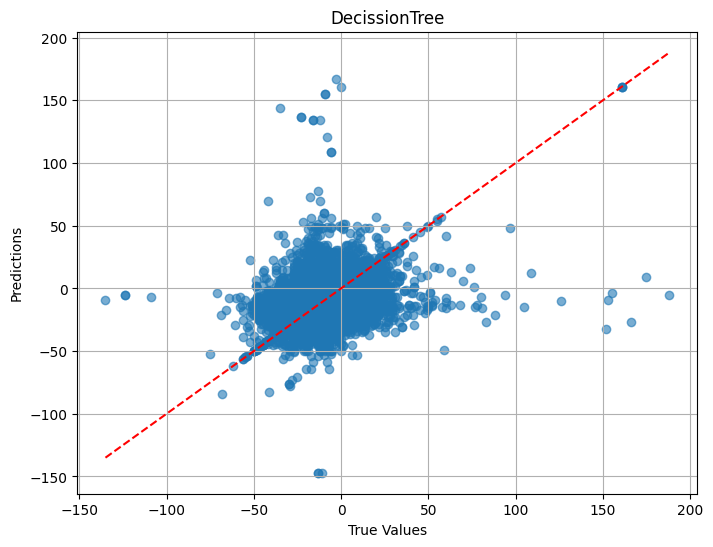

In [10]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred_tree, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # 45-degree line
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('DecissionTree')
plt.grid()
plt.show()

In [ ]:
random_forest_model = models.get("Random Forest", None)
random_forest_model.fit(X_train, y_train)
y_pred_rf = random_forest_model.predict(X_test)
get_statistics(random_forest_model, y_test=y_test, y_pred=y_pred_rf)

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred_rf, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # 45-degree line
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('RandomForest')
plt.grid()
plt.show()

NameError: name 'plt' is not defined

In [ ]:
lineal_regression_model = models.get("Regresión Lineal", None)
lineal_regression_model.fit(X_train, y_train)
y_pred_lineal = lineal_regression_model.predict(X_test)
get_statistics(lineal_regression_model, y_test=y_test, y_pred=y_pred_lineal)

NameError: name 'models' is not defined

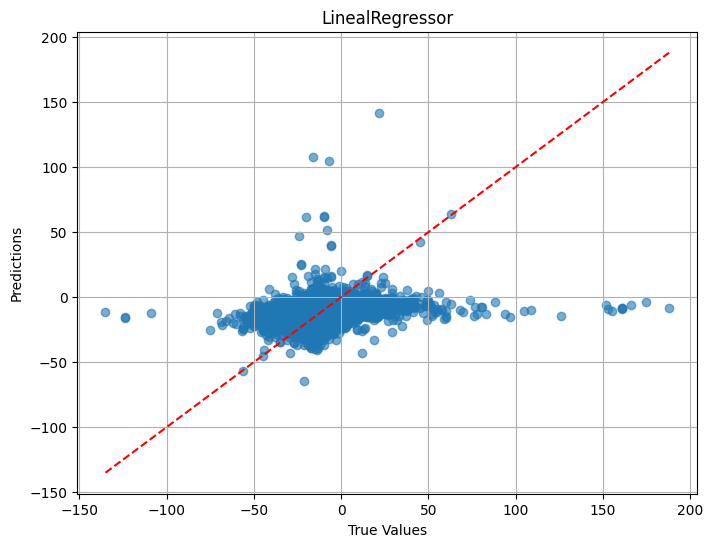

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred_lineal, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # 45-degree line
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('LinealRegressor')
plt.grid()
plt.show()

In [1]:
from sklearn.model_selection import GridSearchCV

# Grid Search para Árbol de Decisión


param_grid_tree = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}

grid_tree = GridSearchCV(
    DecisionTreeRegressor(random_state=42),
    param_grid_tree,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

grid_tree.fit(X_train, y_train)

print("Mejores parámetros para Árbol de Decisión:")
print(grid_tree.best_params_)

# Evaluar con el mejor modelo
y_pred_tree_best = grid_tree.best_estimator_.predict(X_test)
get_statistics(grid_tree.best_estimator_, y_test=y_test, y_pred=y_pred_tree_best)


NameError: name 'DecisionTreeRegressor' is not defined

In [ ]:
# Grid Search para Random Forest


param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}

grid_rf = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid_rf,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

grid_rf.fit(X_train, y_train)

print("Mejores parámetros para Random Forest:")
print(grid_rf.best_params_)

# Evaluar con el mejor modelo
y_pred_rf_best = grid_rf.best_estimator_.predict(X_test)
get_statistics(grid_rf.best_estimator_, y_test=y_test, y_pred=y_pred_rf_best)
